In [13]:
import atlite
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, LineString, Point

import yaml
from yaml.loader import SafeLoader
from urllib.request import urlretrieve

Die 5 Insel sind folgendes
- Batanes
- Bohol
- Catanduanes
- Marinduque
- Tawi-Tawi

In [5]:
turbine_df = pd.read_csv('turbine.csv').rename(columns={'Unnamed: 0':'turbine'}).set_index('turbine')

turbine_typ = ['WES250','Vestas_V25_200kW','VesV20','En18','JI20kW']
island = ["Batanes","Bohol","Catanduanes","Marinduque","Tawi-Tawi"]

nopower_df = pd.DataFrame(columns=island,index=turbine_typ)

for t in power_df.index:
    turbine = turbine_df.loc[t]
    neg_turbine = turbine.copy(deep=True)
    
    for i in neg_turbine.index:
        if neg_turbine.loc[i] == 0:
            neg_turbine.loc[i] = 1
        elif isinstance(neg_turbine.loc[i], float):
            neg_turbine.loc[i] = 0
    
    for r in power_df.columns:
        hub_height = round(float(turbine['HUB_HEIGHT']))
        while True:
            try:
                wind_df = pd.read_csv(f"wind_histogram/wind_hist_{hub_height}_m.csv").rename(columns={'Unnamed: 0':'region'}).set_index('region')
            except FileNotFoundError:
                hub_height = turbine['HUB_HEIGHT']
                continue
            break
        wind = wind_df.loc[r]
        nopower_df.loc[t,r] = sum(neg_turbine.loc[str(n)]*wind.loc[str(n)] for n in range(len(wind)))


In [6]:
#power_df.to_csv('energieertrag_MWh_a.csv')
nopower_df

,Batanes,Bohol,Catanduanes,Marinduque,Tawi-Tawi
WES250,288,2641,1180,2782,2126
Vestas_V25_200kW,629,4333,2685,4488,4486
VesV20,1357,6454,4450,5905,6659
En18,630,4344,2701,4498,4499
JI20kW,1612,7249,4987,6342,7044


In [10]:
def extrapolate_wind_speed(hub_height,year):
    
    # v = v ref ln(z/z 0 )/ln(z ref /z 0 )
    cutout = atlite.Cutout(f"PHL_atlite_{year}.nc")
    wind_100 = cutout.data.wnd100m
    roughness = cutout.data.roughness
    wind_array = wind_100 * np.log(hub_height/roughness)/np.log(100/roughness)
    
    return wind_array

def region_wind(wind_array,region):
    cell_data=[]
    for x in np.arange(116.75,126.57,0.25):
        x = round(x,2)
        for y in np.arange(4.5,21.25,0.25):
            buffer = Point(x, y).buffer(0.25, cap_style = 3)
            if region.simplify(0.1).overlaps(buffer):
                x_cell = int((x - 116.8)*4)
                y_cell = int((y - 4.5)*4)
                cell_data= cell_data + [[y_cell,x_cell]]

    return sum(wind_array[:,y,x].to_pandas() for y,x in cell_data)/len(cell_data)

In [14]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg")

region=10
wind_height=30

wind_array = extrapolate_wind_speed(wind_height,"2020")
wind_series = region_wind(wind_array,regions.geometry[region])

In [16]:
wind_series

time
2020-01-01 00:00:00    14.420557
2020-01-01 01:00:00    14.502035
2020-01-01 02:00:00    14.366391
2020-01-01 03:00:00    14.172201
2020-01-01 04:00:00    13.824707
                         ...    
2020-12-31 19:00:00    11.922174
2020-12-31 20:00:00    11.813945
2020-12-31 21:00:00    11.869819
2020-12-31 22:00:00    11.010721
2020-12-31 23:00:00    11.501553
Length: 8784, dtype: float32

In [17]:
wind_series.to_csv('wind_series_test.csv')

<AxesSubplot:xlabel='time'>

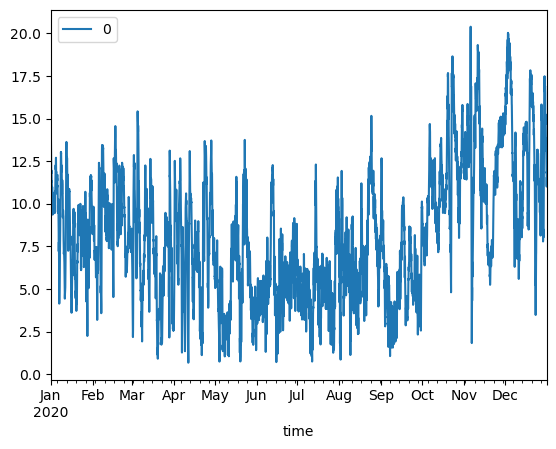

In [35]:
wind_series = pd.read_csv('wind_series_test.csv',index_col=0, parse_dates=True)
wind_series.plot()

In [38]:
for i in wind_series.index:
    if wind_series.loc[i,'0'] < 12:
        wind_series.loc[i,'0'] = 0

wind_series.groupby(wind_series['0'].diff().ne(0).cumsum()).cumcount()

time
2020-01-01 00:00:00    0
2020-01-01 01:00:00    0
2020-01-01 02:00:00    0
2020-01-01 03:00:00    0
2020-01-01 04:00:00    0
                      ..
2020-12-31 19:00:00    0
2020-12-31 20:00:00    1
2020-12-31 21:00:00    2
2020-12-31 22:00:00    3
2020-12-31 23:00:00    4
Length: 8784, dtype: int64

In [39]:
wind_series

,0
time,
2020-01-01 00:00:00,14.420557
2020-01-01 01:00:00,14.502035
2020-01-01 02:00:00,14.366391
2020-01-01 03:00:00,14.172201
2020-01-01 04:00:00,13.824707
...,...
2020-12-31 19:00:00,0.000000
2020-12-31 20:00:00,0.000000
2020-12-31 21:00:00,0.000000
